In [38]:
%tensorflow_version 2.x

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [40]:
#tfds.disable_progress_bar()
train_ds, ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    #split=['train[:90%]', 'train[90%:]'],
)

In [41]:
train_ds = train_ds['train']

In [50]:
# ds_info

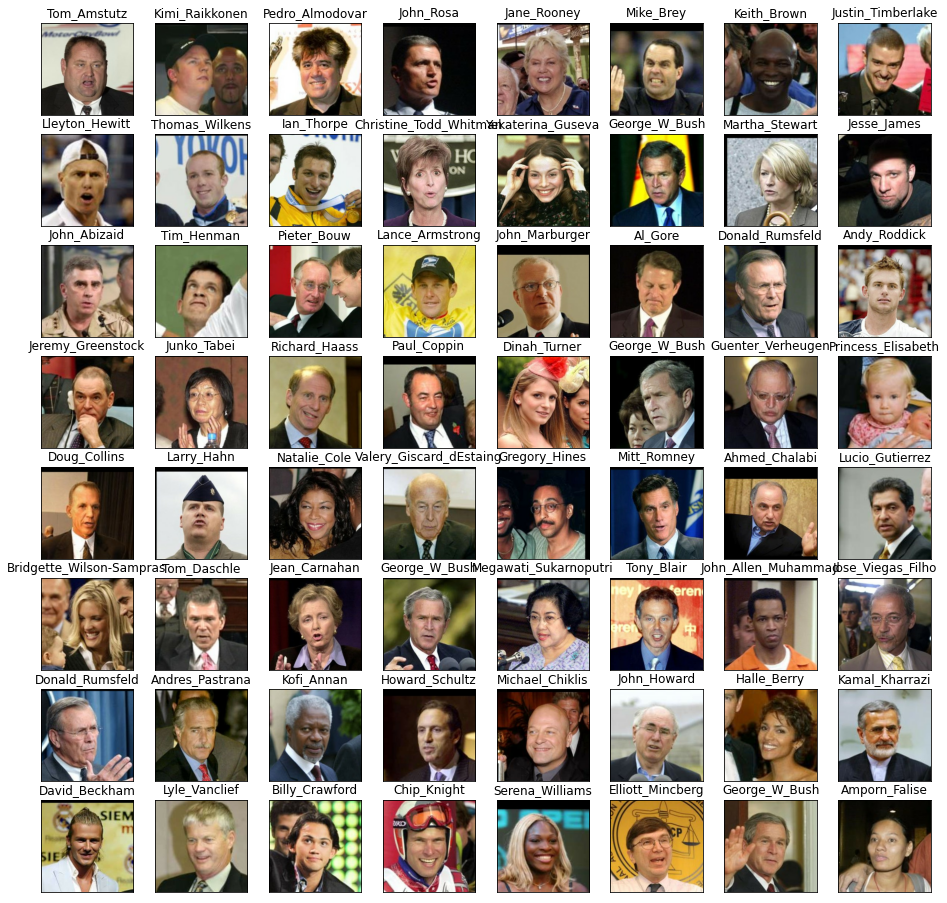

In [47]:
fig = plt.figure(figsize=(16, 16))

for j, (labels, images) in enumerate(iter(train_ds.take(64))):
    numpy_images = images.numpy()
    #numpy_labels = labels.numpy()
    ax = fig.add_subplot(8, 8, j+1)
    ax.imshow(numpy_images)
    plt.xticks([]), plt.yticks([])
    plt.title(labels.numpy().decode("utf-8"))
plt.show()

In [7]:
train_images = list()
train_labels = list()

for (label, image) in iter(train_ds):
  #train_images.append(image)
  train_labels.append(label.numpy().decode("utf-8"))


train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels)

In [8]:
popular_arr = list()
uniq, count = np.unique(train_labels, return_counts =True)
for i in range(len(uniq)):
  popular_arr.append([uniq[i], count[i]])
popular_arr.sort( key = lambda x: x[1], reverse=True)
test_popular_arr = popular_arr[500:505]
popular_arr = popular_arr[:500]
test_popular_person = [i[0] for i in test_popular_arr]
popular_person = [i[0] for i in popular_arr]

In [9]:
train_images = list()
train_labels = list()

for (label, image) in iter(train_ds):
  if label.numpy().decode("utf-8") in popular_person:
    train_images.append(image)
    train_labels.append(label.numpy().decode("utf-8"))


train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels)

test_images = list()
test_labels = list()

for (label, image) in iter(train_ds):
  if label.numpy().decode("utf-8") in test_popular_person:
    test_images.append(image)
    test_labels.append(label.numpy().decode("utf-8"))


test_images = np.array(test_images, dtype='float32')
test_labels = np.array(test_labels)

In [10]:
train_images.shape

(6293, 250, 250, 3)

In [11]:
train_labels.shape

(6293,)

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
print(train_ds)

<TensorSliceDataset shapes: ((250, 250, 3), ()), types: (tf.float32, tf.string)>


In [13]:
INP_SIZE = 250
NUM_EPOCHS = 10
BATCH_SIZE = 64

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.repeat(NUM_EPOCHS)

# test_ds = test_ds.shuffle(buffer_size=1000)
# test_ds = test_ds.map(prepare)
# test_ds = test_ds.batch(32, drop_remainder=True)

In [14]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [15]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [16]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [17]:

for iteration, (data) in enumerate(train_ds):
    images, labels = data[0], data[1]
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 94.17800903320312
[50] Loss: 16.93271827697754
[100] Loss: 8.481264114379883
[150] Loss: 0.12895755469799042
[200] Loss: 1.289837121963501
[250] Loss: 0.054818201810121536
[300] Loss: 0.26275452971458435
[350] Loss: 9.816025733947754
[400] Loss: 0.0023579830303788185
[450] Loss: 3.930852174758911
[500] Loss: 0.4476456046104431
[550] Loss: 0.08799479156732559
[600] Loss: 2.1703643798828125
[650] Loss: 0.0
[700] Loss: 0.7399678230285645
[750] Loss: 0.001916565583087504
[800] Loss: 19.608802795410156
[850] Loss: 3.623079538345337
[900] Loss: 3.190375804901123
[950] Loss: 0.7397588491439819


In [18]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

def prepare_img(img):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)).numpy()

def diff_img(img1, img2):
  fig = plt.figure(figsize=(8, 6))

  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(img1.astype('int'))

  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(img2.astype('int'))

  plt.show()

  img1 = prepare_img(img1)
  img2 = prepare_img(img2)

  img1_emb = model(img1.reshape(1, INP_SIZE, INP_SIZE, 3))
  img2_emb = model(img2.reshape(1, INP_SIZE, INP_SIZE, 3))

  return diff(img1_emb, img2_emb)



In [19]:
test_labels

array(['Hun_Sen', 'Helen_Clark', 'Hipolito_Mejia', 'Herb_Sendek',
       'Helen_Clark', 'Hipolito_Mejia', 'Hun_Sen', 'Hipolito_Mejia',
       'Heidi_Fleiss', 'Hipolito_Mejia', 'Helen_Clark', 'Heidi_Fleiss',
       'Helen_Clark', 'Hun_Sen', 'Heidi_Fleiss', 'Hun_Sen', 'Herb_Sendek',
       'Heidi_Fleiss', 'Herb_Sendek', 'Herb_Sendek'], dtype='<U14')

In [20]:
np.where(test_labels == 'Hun_Sen')

(array([ 0,  6, 13, 15]),)

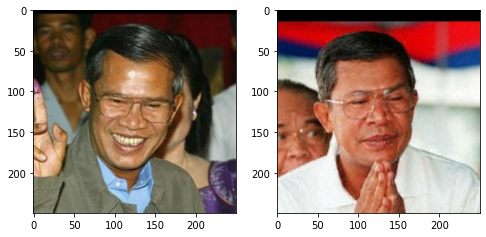

12.948283690787338

In [32]:
diff_img(test_images[6], test_images[0])

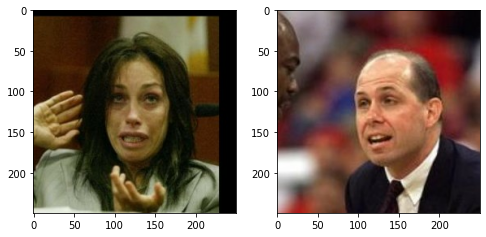

26.205095520718867

In [48]:
diff_img(test_images[11], test_images[3])

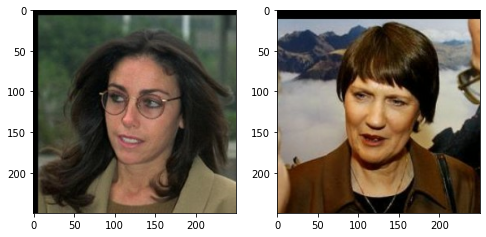

16.06896794934358

In [23]:
diff_img(test_images[8], test_images[12])

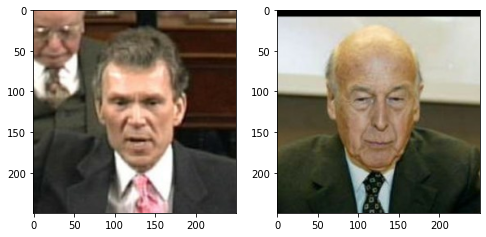

21.57382656544224

In [49]:
diff_img(train_images[18], train_images[15])